# Estimate Self-influence 

1) Import of necessary libraries:

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

1) Dataset is fetched and separated into features X and labels y, then it is scaled.

In [2]:
data = fetch_california_housing()
X = data.data.astype(np.float32)
y = data.target

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

2) The network is modeled to resemble the Network used in the paper, with 3 hidden layers and 162K parameters:



In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(8, 400)
        self.fc2 = nn.Linear(400, 400)
        self.fc3 = nn.Linear(400, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

3) Dataset is prepared for the training by splitting it into Train set and Test set with a 8:2 ratio. The two sets are then converted into tensors.

In [4]:
# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)
# Convert numpy arrays to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float)
Y_train = torch.tensor(Y_train, dtype=torch.float).view(-1, 1)

4) Now the checkpoints are loaded from the folder where they were saved after training. This is made to resemble the original implementation of the paper, where every 20th checkpoint is used to perform TracIn influences.

In [5]:
def load_checkpoints(path, checkpoints):
  models = []
  last_layers_weights = []
  for i in checkpoints:
    model = Net()
    model.load_state_dict(torch.load(ph+str(i)+"chpcheckpoint.pth.tar"))
    last_layers_weights.append(model.fc3.weight)
    models.append(model)
  return models, last_layers_weights

5)

In [6]:
def run_self_influence(loss, models, model_params):
    self_influences = np.zeros(len(X_train))
    for i in tqdm(range(len(models))):
      m = models[i]
      m.to(device)
      for j in range(len(X_train)):
        pred = m(X_train[j].to(device))
        criterion = loss(pred, Y_train[j].to(device))
        grads = torch.autograd.grad(criterion, model_params[i])
        score = torch.stack([torch.sum(
        grad * grad, axis=list(range(1, grad.dim()))) for grad in grads])

        self_influences[j] += score
    return self_influences

6) The next 3 cells can be executed to show the plot of the self influences calculated with checkpoints of batch size 64

In [18]:
ph = "./CHP_checkpoints/batch_64/"
models, last_layers_weights = load_checkpoints(ph, range(0, 200, 10))

In [19]:
loss = nn.MSELoss()
self_influences = run_self_influence(loss, models, last_layers_weights)

100%|██████████| 20/20 [04:27<00:00, 13.36s/it]


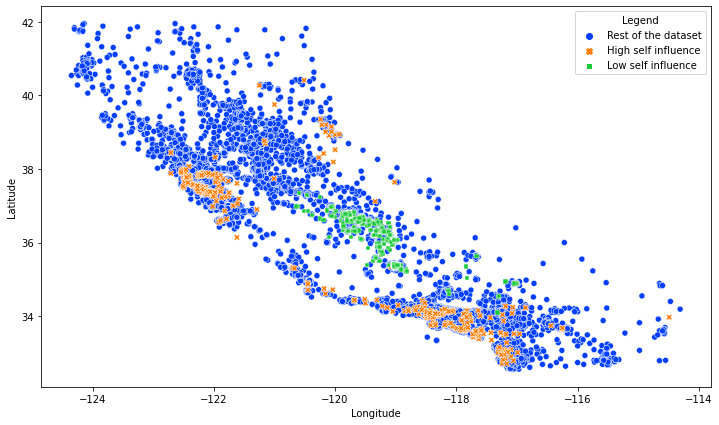

In [10]:
california_frame = fetch_california_housing(as_frame=True)
train_data_frame, test_data_frame = train_test_split(california_frame.data, test_size=0.2, random_state=42)

self_influences_copy = self_influences.copy()

scalar_list = [tensor.item() for tensor in self_influences_copy]
# last 100
max_scores_indices = []
max_val_indices = sorted(range(len(self_influences_copy)), key = lambda sub: scalar_list[sub])[-400:]
max_val_indices[0:5]

min_scores_indices = []
min_val_indices = sorted(range(len(self_influences_copy)), key = lambda sub: scalar_list[sub])[:400]
min_val_indices[0:5]

# Create a new column 'new_column' and initialize it with zeros
train_data_frame.reset_index(inplace=True, drop=True)
train_data_frame['new_column'] = 0
# Set the value to 1 for rows at 'max_val_indices'
train_data_frame.loc[max_val_indices, 'new_column'] = 1
train_data_frame.loc[min_val_indices, 'new_column'] = 2

train_data_frame['Legend'] = 'Rest of the dataset'
# Set the value to 1 for rows at 'max_val_indices'
train_data_frame.loc[max_val_indices, 'Legend'] = 'High self influence'
train_data_frame.loc[min_val_indices, 'Legend'] = 'Low self influence'

train_data_frame = train_data_frame.sort_values('new_column', ascending=True)

plt.figure(figsize=(12,7))
sns.scatterplot(data = train_data_frame, x='Longitude', y='Latitude', hue='Legend', palette="bright", style='Legend')
#plt.show()
plt.savefig('prop-opp-64.png')

7) The next 3 cells can be executed to show the plot of the self influences calculated with checkpoints of batch size 32

In [22]:
ph = "./CHP_checkpoints/batch_32/"
models, last_layers_weights = load_checkpoints(ph, range(0, 200, 10))

In [23]:
loss = nn.MSELoss()
self_influences = run_self_influence(loss, models, last_layers_weights)

100%|██████████| 20/20 [04:22<00:00, 13.14s/it]


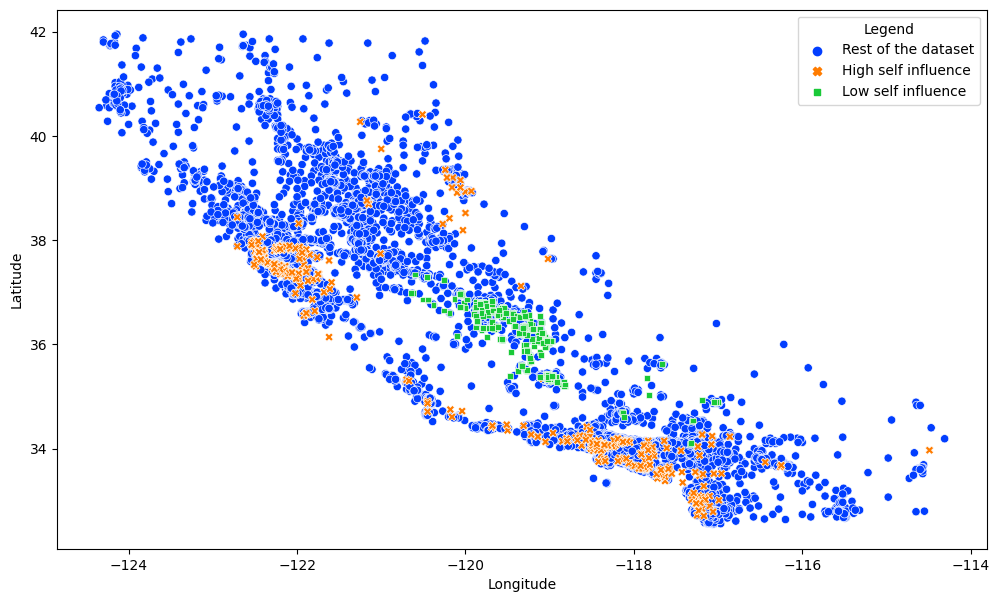

In [36]:
california_frame = fetch_california_housing(as_frame=True)
train_data_frame, test_data_frame = train_test_split(california_frame.data, test_size=0.2, random_state=42)

self_influences_copy = self_influences.copy()

scalar_list = [tensor.item() for tensor in self_influences_copy]
# last 100
max_scores_indices = []
max_val_indices = sorted(range(len(self_influences_copy)), key = lambda sub: scalar_list[sub])[-400:]
max_val_indices[0:5]

min_scores_indices = []
min_val_indices = sorted(range(len(self_influences_copy)), key = lambda sub: scalar_list[sub])[:400]
min_val_indices[0:5]

# Create a new column 'new_column' and initialize it with zeros
train_data_frame.reset_index(inplace=True, drop=True)
train_data_frame['new_column'] = 0
# Set the value to 1 for rows at 'max_val_indices'
train_data_frame.loc[max_val_indices, 'new_column'] = 1
train_data_frame.loc[min_val_indices, 'new_column'] = 2

train_data_frame['Legend'] = 'Rest of the dataset'
# Set the value to 1 for rows at 'max_val_indices'
train_data_frame.loc[max_val_indices, 'Legend'] = 'High self influence'
train_data_frame.loc[min_val_indices, 'Legend'] = 'Low self influence'

train_data_frame = train_data_frame.sort_values('new_column', ascending=True)

plt.figure(figsize=(12,7))
sns.scatterplot(data = train_data_frame, x='Longitude', y='Latitude', hue='Legend', palette="bright", style='Legend')
#plt.show()
plt.savefig('prop-opp-32.png')

6) The next 3 cells can be executed to show the plot of the self influences calculated with checkpoints of batch size 8

In [8]:
ph = "./CHP_checkpoints/batch_8/"
models, last_layers_weights = load_checkpoints(ph, range(0, 200, 10))

In [9]:
loss = nn.MSELoss()
self_influences = run_self_influence(loss, models, last_layers_weights)
california_frame = fetch_california_housing(as_frame=True)

100%|███████████████████████████████████████████| 20/20 [04:10<00:00, 12.51s/it]


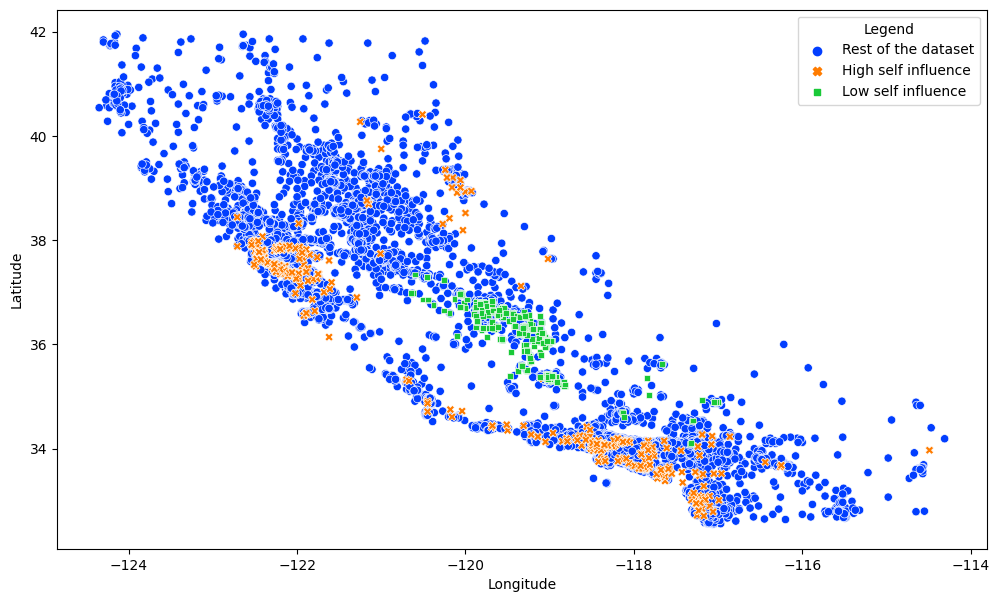

In [37]:
train_data_frame, test_data_frame = train_test_split(california_frame.data, test_size=0.2, random_state=42)

self_influences_copy = self_influences.copy()

scalar_list = [tensor.item() for tensor in self_influences_copy]

max_scores_indices = []
max_val_indices = sorted(range(len(self_influences_copy)), key = lambda sub: scalar_list[sub])[-400:]
max_val_indices[0:5]

min_scores_indices = []
min_val_indices = sorted(range(len(self_influences_copy)), key = lambda sub: scalar_list[sub])[:400]
min_val_indices[0:5]

# Create a new column 'new_column' and initialize it with zeros
train_data_frame.reset_index(inplace=True, drop=True)
train_data_frame['new_column'] = 0
# Set the value to 1 for rows at 'max_val_indices'
train_data_frame.loc[max_val_indices, 'new_column'] = 1
train_data_frame.loc[min_val_indices, 'new_column'] = 2

train_data_frame['Legend'] = 'Rest of the dataset'
# Set the value to 1 for rows at 'max_val_indices'
train_data_frame.loc[max_val_indices, 'Legend'] = 'High self influence'
train_data_frame.loc[min_val_indices, 'Legend'] = 'Low self influence'

train_data_frame = train_data_frame.sort_values('new_column', ascending=True)

plt.figure(figsize=(12,7))
sns.scatterplot(data = train_data_frame, x='Longitude', y='Latitude', hue='Legend', palette="bright", style='Legend')
#plt.show()
plt.savefig('prop-opp-8.png')

7) Here a visual comparison of the three experiments is plotted side by side. The configuration which resembles the most to the paper's experiment is the one

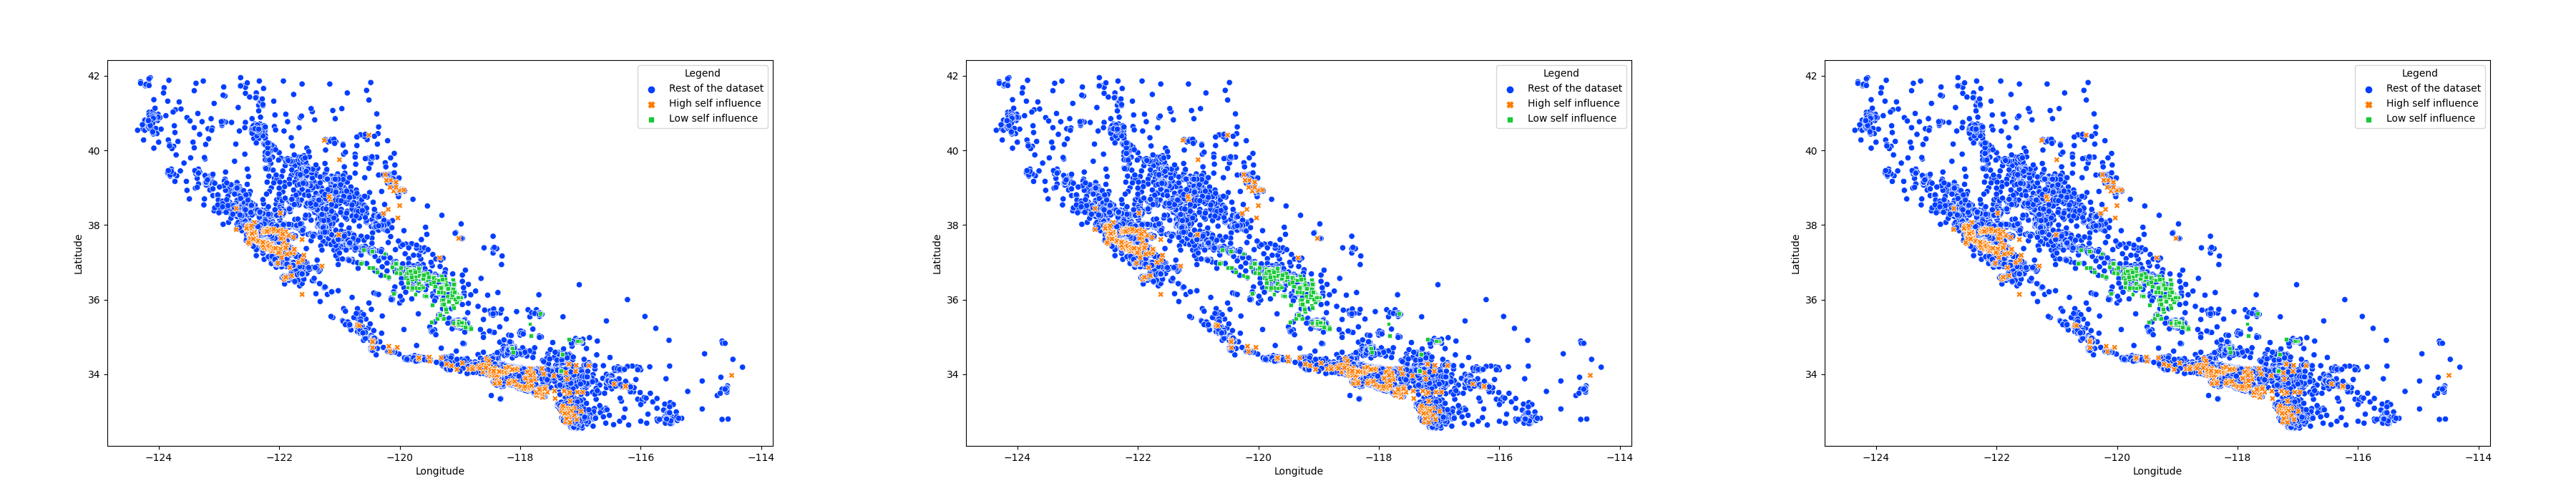

In [38]:
# Load the three images
image1 = Image.open('prop-opp-64.png')
image2 = Image.open('prop-opp-32.png')
image3 = Image.open('prop-opp-8.png')

# Adjust the size of the images (if needed)
# image1 = image1.resize((width, height))
# image2 = image2.resize((width, height))
# image3 = image3.resize((width, height))

# Convert the images to NumPy arrays
array1 = np.array(image1)
array2 = np.array(image2)
array3 = np.array(image3)

# Horizontally concatenate the image arrays
concatenated_array = np.concatenate((array1, array2, array3), axis=1)

# Convert the concatenated array back to an image
concatenated_image = Image.fromarray(concatenated_array)

# Display the concatenated image
concatenated_image.show()